# 제주도 버스승차 인원 예측
- ## data 415423 rows × 49 columns
### Columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수
- 지번주소 : EDA 및 제주 날씨 merge용 column 
- si :EDA 및 제주 날씨 merge용 column 
- city : EDA 및 제주 날씨 merge용 column  
- dong : EDA 및 제주 날씨 merge용 column  
- road_addr : EDA 및 제주 날씨 merge용 column  
- weather_addr : EDA 및 제주 날씨 merge용 column 
- temperature : 온도
- precipitation : 강수량
- bus_interval : 노선 배차 간격
- date_day : 일 (1일 ~ 30일)
- date_dayofweek : 요일 (0 ~ 6)
- date_dayofname : 요일 (월 ~ 일)
- weekday : 평일 여부
- weekend : 주말 여부
- holiday : 공휴일 여부
- typhoon : 태풍이 온날
- in_ : 시내 버스 구분
- out : 시외 버스 구분
- ridexx : ride(탑승)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- offxx : off(하차)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ride_sum : 승차인원의 합계
- off_sum : 하차인원의 합계
- bus_route_id_sum : 정류소, 일별 운행한 버스노선의 갯수
- bus_route_id_all_sum : 정류소별 9월 전체 운행한 버스노선의 갯수



### 0. 공통

In [2]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
from sklearn.externals import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import count
import plotly_express as px
from tqdm.notebook import tqdm
import geopy.distance

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
pd.set_option('max_columns', 700)
pd.set_option('max_rows', 500)

### 01. 데이터 전처리 부분 (컬럼 추가, 삭제 등)

In [14]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [15]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [16]:
# 주소 데이터 가져오기
jeju_addr=pd.read_csv('jeju_addr.csv')
train = pd.merge(train, jeju_addr, on= 'station_code')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr
415421,400433,2019-09-30,22210000,시내,1585,셰프라인월드,33.43489,126.73242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 구좌읍 송당리 2635-3,제주시,구좌읍,송당리,비자림로
415422,406662,2019-09-30,27180000,시내,3552,행원교차로,33.54574,126.80370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 구좌읍 행원리 1180-3,제주시,구좌읍,행원리,일주동로


In [17]:
# 날씨 추가

# date 타입 변경
train['date'] = train['date'].astype('datetime64')

# 날씨 가져오기
#weather 데이터를 추가하기 전 실행해주세요!
jeju=['제주시','애월읍','조천읍']
seogipo=['서귀포시','남원읍','안덕면']
sungsan=['성산읍','구좌읍','우도면','표선면']
gosan=['한경면','한림읍','대정읍']
chuga=['추자면']
weather_addr=[]
for city in train['city']:
    if city in jeju: weather_addr.append('제주')
    elif city in seogipo: weather_addr.append('서귀포')
    elif city in gosan : weather_addr.append('고산')
    elif city in sungsan : weather_addr.append('성산')
    elif city in chuga : weather_addr.append('추자')    
#weather_addr 컬럼 생성
train['weather_addr']=weather_addr
weather=pd.read_excel('all_weather.xlsx')
train = pd.merge(train, weather, on= ['weather_addr','date'])
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1


In [18]:
# 배차간격 추가
bus_interval = pd.read_csv('bus_interval_final.csv')
train = pd.merge(train, bus_interval, how='left', on='bus_route_id')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0


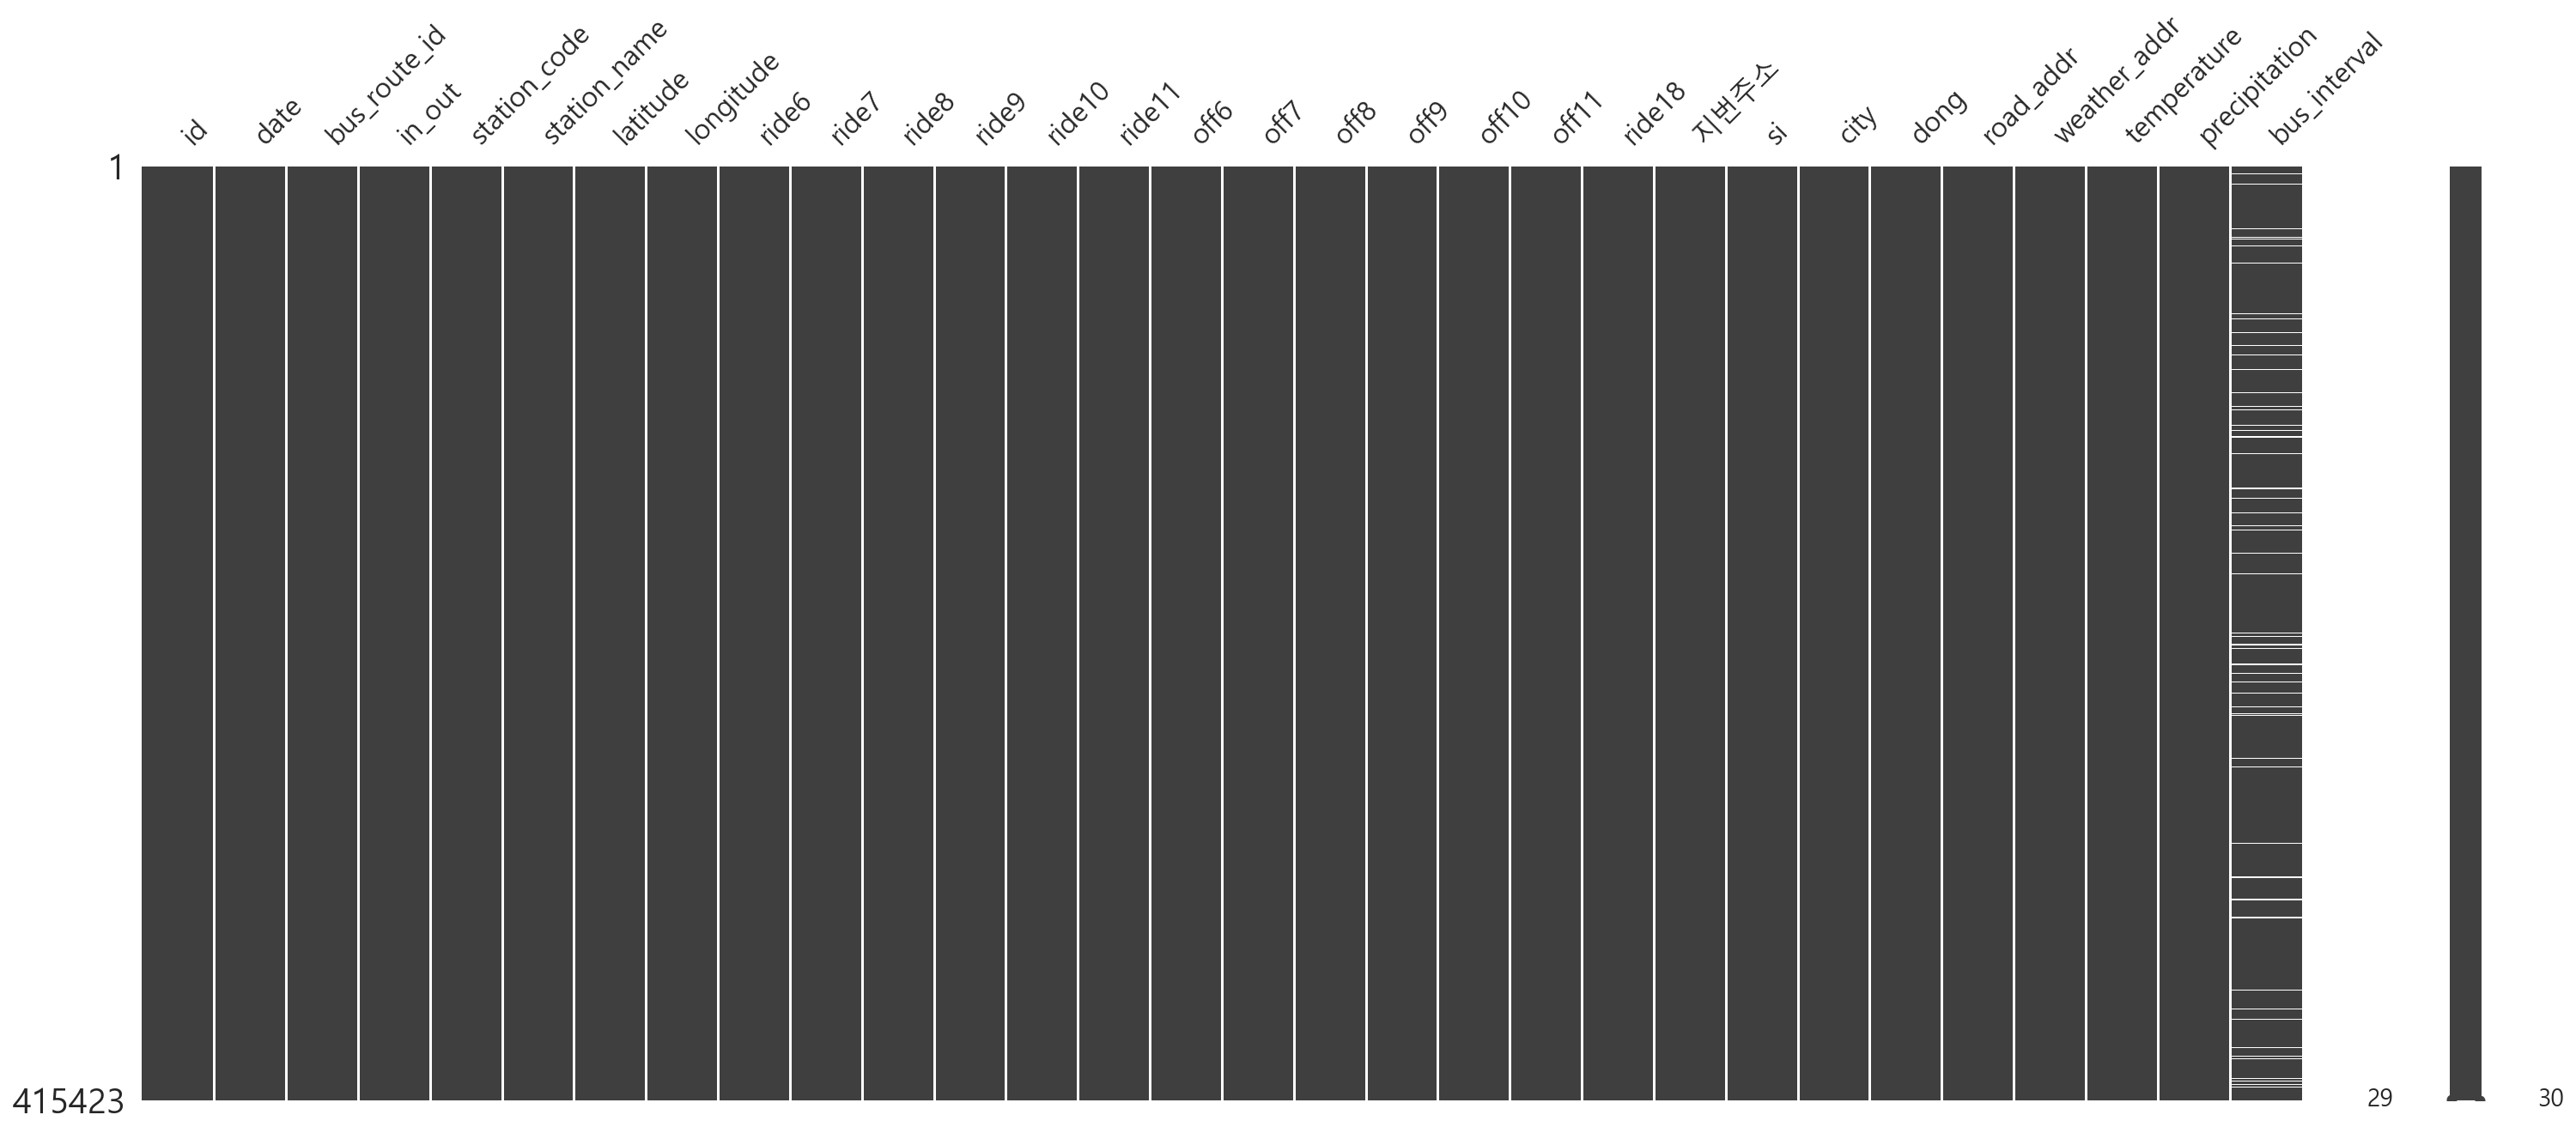

In [19]:
# Nan data 확인
missingno.matrix(train)
plt.show()

In [20]:
# 배차간격에 Nan값 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  object        
 4   station_code   415423 non-null  int64         
 5   station_name   415423 non-null  object        
 6   latitude       415423 non-null  float64       
 7   longitude      415423 non-null  float64       
 8   ride6          415423 non-null  float64       
 9   ride7          415423 non-null  float64       
 10  ride8          415423 non-null  float64       
 11  ride9          415423 non-null  float64       
 12  ride10         415423 non-null  float64       
 13  ride11         415423 non-null  float64       
 14  off6           415423 non-null  float64       
 15  

In [21]:
# 배차간격이 없는것은 너무오래 안다니는것으로 999로 변경
train['bus_interval'].fillna(999, inplace = True)

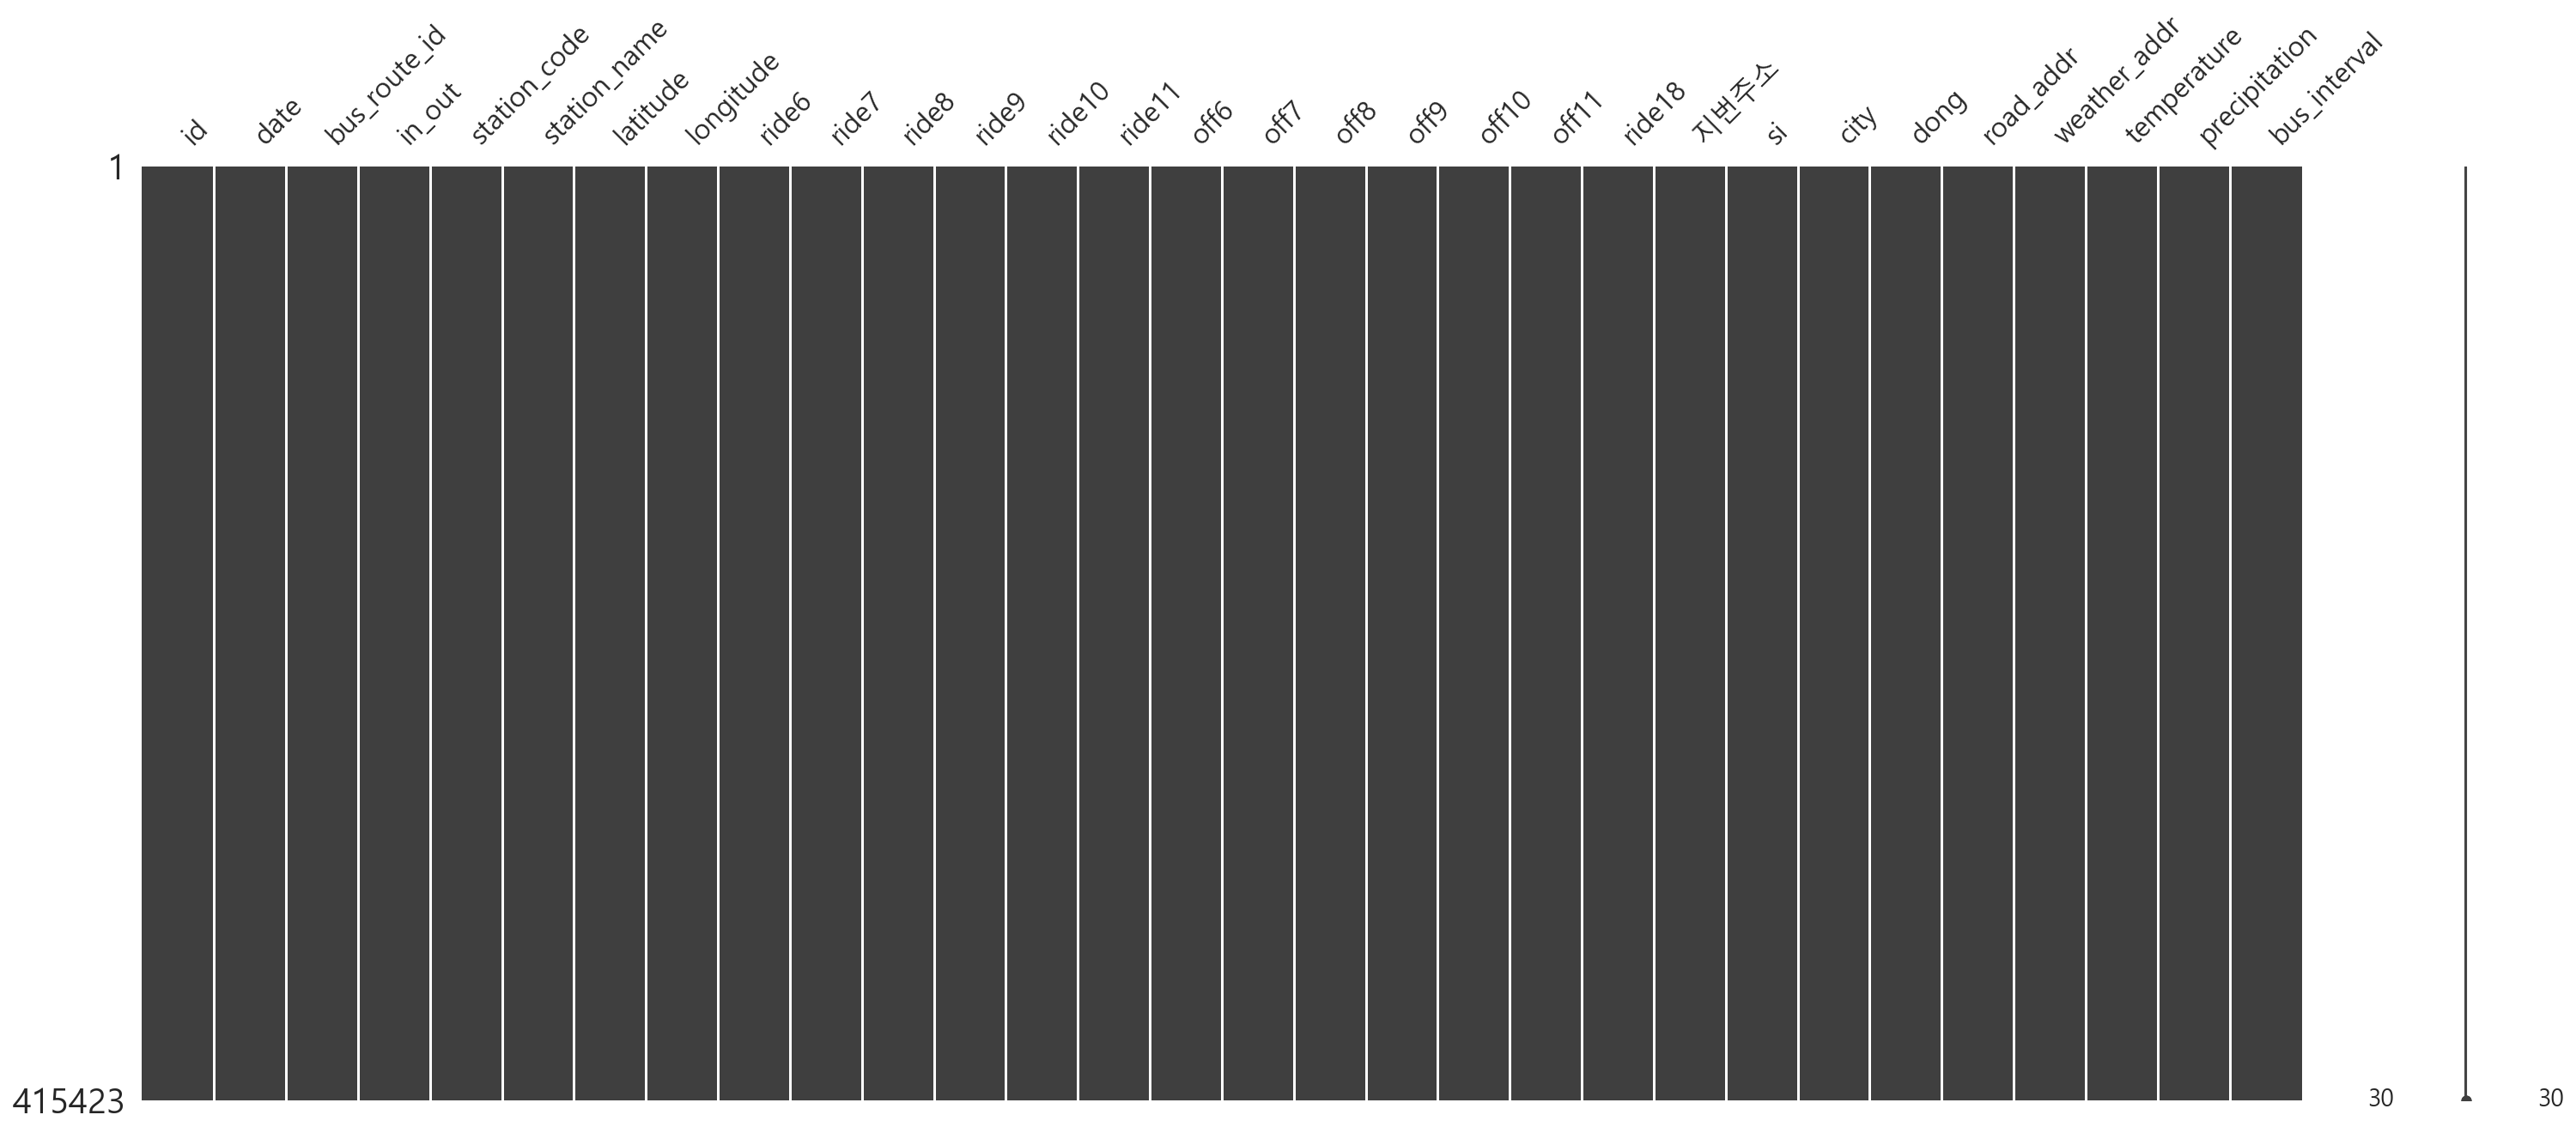

In [22]:
# Nan data 확인
missingno.matrix(train)
plt.show()

In [23]:
# 정확히 Nan값이 없는것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  object        
 4   station_code   415423 non-null  int64         
 5   station_name   415423 non-null  object        
 6   latitude       415423 non-null  float64       
 7   longitude      415423 non-null  float64       
 8   ride6          415423 non-null  float64       
 9   ride7          415423 non-null  float64       
 10  ride8          415423 non-null  float64       
 11  ride9          415423 non-null  float64       
 12  ride10         415423 non-null  float64       
 13  ride11         415423 non-null  float64       
 14  off6           415423 non-null  float64       
 15  

In [24]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())
# date 타입 변경
# train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.day_name()
train[['date','date_dayofweek','date_day','date_dayofname']]

# 평일과 휴일의 원핫 인코딩
train.loc[train['date_dayofweek'] == 0, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 1, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 2, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 3, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 4, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 5, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 6, 'weekday' ] = 0

#Weekend 주말
train.loc[train['date_dayofweek'] == 0, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 1, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 2, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 3, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 4, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 5, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 6, 'weekend' ] = 1

# 추석 추가도 공휴일로 처리
train['holiday'] = 0
train.loc[train['date'] == '2019-09-14', 'holiday'] = 1
train.loc[train['date'] == '2019-09-13', 'holiday'] = 1
train.loc[train['date'] == '2019-09-12', 'holiday'] = 1

# 태풍의 컬럼 추가
train['typhoon'] = 0
train.loc[train['date'] == '2019-09-06', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-07', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-21', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-22', 'typhoon'] = 1

train.tail(2)

2019-09-01 00:00:00
2019-09-30 00:00:00


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1


In [25]:
# 시내, 시외 원핫 인코딩
in_out = pd.get_dummies(train['in_out'])
in_out.columns = ['in_', 'out']
train = pd.concat([train, in_out], axis = 1)
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0


In [26]:
# 2시간 노선 만들기
train['ride67'] = train['ride6'] + train['ride7']
train['ride89'] = train['ride8'] + train['ride9']
train['ride1011'] = train['ride10'] + train['ride11']
train['off67'] = train['off6'] + train['off7']
train['off89'] = train['off8'] + train['off9']
train['off1011'] = train['off10'] + train['off11']
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# 탑승의 총합 만들기
train['ride_sum'] = train['ride6'] + train['ride7'] + train['ride8'] + train['ride9'] + train['ride10'] + train['ride11']

In [28]:
# 하차의 총합만들기
train['off_sum'] = train['off6'] + train['off7'] + train['off8'] + train['off9'] + train['off10'] + train['off11']

In [29]:
# 일별, 정류장별 버스노선 갯수
station_table = pd.pivot_table(index=['station_code', 'date'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'date', 'bus_route_id_sum']
train = pd.merge(train, station_table, how='left', on=['station_code', 'date'])

# 정류장별 버스노선의 갯수
station_table = pd.pivot_table(index=['station_code'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'bus_route_id_all_sum']
train = pd.merge(train, station_table, how='left', on=['station_code'])

train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011,ride_sum,off_sum,bus_route_id_sum,bus_route_id_all_sum
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2,13
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1


In [30]:
# 컬럼별 값들의 갯수는?
for i in train.columns:
    print(f'{i}의 갯수는 ',len(train[i].unique()))

id의 갯수는  415423
date의 갯수는  30
bus_route_id의 갯수는  613
in_out의 갯수는  2
station_code의 갯수는  3563
station_name의 갯수는  1961
latitude의 갯수는  3278
longitude의 갯수는  3446
ride6의 갯수는  47
ride7의 갯수는  80
ride8의 갯수는  78
ride9의 갯수는  66
ride10의 갯수는  66
ride11의 갯수는  69
off6의 갯수는  35
off7의 갯수는  51
off8의 갯수는  53
off9의 갯수는  46
off10의 갯수는  47
off11의 갯수는  55
ride18의 갯수는  170
지번주소의 갯수는  2774
si의 갯수는  2
city의 갯수는  14
dong의 갯수는  178
road_addr의 갯수는  727
weather_addr의 갯수는  5
temperature의 갯수는  62
precipitation의 갯수는  66
bus_interval의 갯수는  140
date_day의 갯수는  30
date_dayofweek의 갯수는  7
date_dayofname의 갯수는  7
weekday의 갯수는  2
weekend의 갯수는  2
holiday의 갯수는  2
typhoon의 갯수는  2
in_의 갯수는  2
out의 갯수는  2
ride67의 갯수는  98
ride89의 갯수는  107
ride1011의 갯수는  97
off67의 갯수는  66
off89의 갯수는  75
off1011의 갯수는  84
ride_sum의 갯수는  216
off_sum의 갯수는  160
bus_route_id_sum의 갯수는  63
bus_route_id_all_sum의 갯수는  555


In [33]:
# 415423 rows × 49 columns
train = train.sort_values('id').reset_index(drop = True)
train.tail(2)

(415423, 49)

In [ ]:
# # 데이터 저장
# 저장된 데이터를 드렸으니, 해당 행은 실행할 필요없습니다.
# train.to_csv('raw_train.csv',encoding='utf-8',index = False)